In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import subprocess
import time
from typing import List
import ftd2xx as ftd

try:
	import ftd2xx as ftd
except: # Download ftd2xx for new CCD (requires FTD libraries)  
	subprocess.run(["pip","install","ftd2xx"])
	try:
		import ftd2xx as ftd
	except:
		print("WARNING: CCD Libraries not installed")

class DeviceSettings():
    #This class containts the settings for the different alphalas types
    def __init__(self):
        #Names for the compatible devices
        self.possibleDevices = ['ALPHALAS CCD-2000-D(-UV)' ,'CCD-S3600-D(-UV) B']

    def update(self, settings):
        #Update the settings of the different alphalas types
        self.settings = {
            self.possibleDevices[0] : {
                "array_size" : 2048,
                "min_inttime" : 5000, #in us
            },
            self.possibleDevices[1] : {
                "array_size" : 3648,
                "min_inttime" : 10, #in us
            }
        }
        self.commands = {
            self.possibleDevices[0] : {
                #Commands for setting the data format to binary
                "initialize" : {
                    'writeCommands' : [b'F0\r'], 
                    'readCommands' : [3]
                },
                #Commands for setting the integration time (in ms)
                "set_integration_time" : {
                    'writeCommands' :  [str.encode("I{0}\r".format(int(settings["integration_time"] / 1000)))], 
                    'readCommands' : [4]
                },
                #Commands for setting the amount of shots per acquisition
                "set_shots_per_acq" : {
                    'writeCommands' : [str.encode("R{0}\r".format(settings["shots_per_acq"]))], 
                    'readCommands' : [4]
                },
                #Set the trigger mode of the alphalas to software trigger
                "set_trigger" : {
                    'writeCommands' : [b'E1\r'], 
                    'readCommands' : [3]
                },
                #Commands for starting the acquisition
                "start_acquisition" : {
                    'writeCommands' : [b'S\r'], 
                    'readCommands' : []
                },
                #Wait untill the CCD is ready
                "wait_for_data_fetch" : {
                    "function" : "read",
                    "value" : b'DONE\r'
                },
                #Ask the CCD to fetch the data
                "fetch_readout" : {
                    'writeCommands' : [b'G\r'], 
                    'readCommands' : [4096]
                }
            },
            self.possibleDevices[1] : {
                #Command for setting the integration time (in us)
                "set_integration_time" : {
                    'writeCommands' : [b'\xc1', settings['integration_time'].to_bytes(4, 'big')], 
                    'readCommands' : [1]
                },
                #Command for setting the amount of shots per acquisition
                "set_shots_per_acq" : {
                    'writeCommands' : [b'\xc2', settings["shots_per_acq"].to_bytes(4, 'big')], 
                    'readCommands' : [1]
                },
                #Set the trigger mode of the alphalas to software trigger
                "set_trigger" : {
                    'writeCommands' : [b'\xc3', (0).to_bytes(1, 'big')], 
                    'readCommands' : [1]
                },
                #Turn on/off the dark correction
                "set_dark_correction" : {
                    'writeCommands' : [b'\xc5', settings["dark_correction"].to_bytes(1, 'big')], 
                    'readCommands' : [1]
                },
                #Command for starting the acquisition
                "start_acquisition" : {
                    'writeCommands' : [b'\xc6'], 
                    'readCommands' : []
                },
                #Wait untill the CCD is ready
                "wait_for_data_fetch" : {
                    "function" : 'getQueueStatus',
                    'value' : 7296
                },
                #Ask the CCD to fetch the data
                "fetch_readout" : {
                    'writeCommands' : [], 
                    'readCommands' : [7296]
                }
            }
        }

class AlphalasCCD():
    #This class contains all the functions regarding the CCD

    def __init__(self):
        self.deviceSettings = DeviceSettings()

        #Some general settings for the CCD
        self.settings = {
            "integration_time" : 5000, #integration time in us
            "timeout_time" : 500,
            "shots_per_acq" : 1,
            "trigger" : 1,
            "dark_correction" : 0,
        }

        self.deviceSettings.update(self.settings)
        self.initializeCCD()

    def initializeCCD(self):
        devices = ftd.listDevices(2)

        if not devices:
            self.device = 0
            return 0
        
        #Search for the compatible devices
        for i in range(len(devices)):
            if devices[i].decode('utf-8') in self.deviceSettings.possibleDevices:
                self.ccdString = devices[i].decode('utf-8')
                self.device = ftd.open(i)
                self.device.setTimeouts(self.settings['timeout_time'], self.settings['timeout_time'])
        
        if not self.ccdString:
            self.device = 0
            return 0

        #Print the details of the CCD
        print("Connected to device: \n" + str(ftd.getDeviceInfoDetail()))
        
        #Execute the commands to setup the CCD
        self.executeCommand("initialize")
        self.executeCommand("set_integration_time")
        self.executeCommand("set_shots_per_acq")
        self.executeCommand("set_trigger")
        self.executeCommand("set_dark_correction")

        self.prepared_shots = 0
    
    def getArraySize(self):
        #Get the array size of the CCD
        return self.deviceSettings.settings[self.ccdString]['array_size']

    def executeCommand(self, command):
        #Execute a given command
        response = []

        #Check if command exists
        if command in self.deviceSettings.commands[self.ccdString]:
            writeCommands = self.deviceSettings.commands[self.ccdString][command]['writeCommands']
            readCommands = self.deviceSettings.commands[self.ccdString][command]['readCommands']

            #Execute the write commands
            for writeCommand in writeCommands:
                self.device.write(writeCommand)

            #Execute the read commands
            for readCommand in readCommands:
                response.append(self.device.read(readCommand))

        return response

    def update_integration_time(self, inttime):
        #Check if the inttime is not smaller than the minimum inttime
        inttime = max(inttime, self.deviceSettings.settings[self.ccdString]['min_inttime'])

        #Set the inttime if not already set
        if inttime != self.settings['integration_time']:
            self.settings['integration_time'] = inttime
            self.deviceSettings.update(self.settings)
            self.executeCommand("set_integration_time")

    def update_shots_per_acq(self, shots_per_acq):
        #Set the amount of shots per acquisition if not already set
        if shots_per_acq != self.settings["shots_per_acq"]:
            self.settings["shots_per_acq"] = shots_per_acq
            self.deviceSettings.update(self.settings)
            self.executeCommand("set_shots_per_acq")

    def readOutData(self):
        #read out the data

        #Prepare the CCD for the data acquisition
        self.prepare_for_acquisition()

        alldata = np.zeros((self.settings['shots_per_acq'], self.deviceSettings.settings[self.ccdString]['array_size']))
       
        #Loop through the shots per acq
        for i in range(self.settings["shots_per_acq"]):
            #Fetch a single readout
            alldata[i] = self.fetch_single_readout()

        return np.mean(alldata, axis = 0)

    def prepare_for_acquisition(self):
        #Prepares the CCD for acquisition
        self.executeCommand("start_acquisition")

        #Wait until the CCD is ready if necessary
        if self.deviceSettings.commands[self.ccdString]['wait_for_data_fetch']['function'] == 'read':
            response = ''
            while response != self.deviceSettings.commands[self.ccdString]['wait_for_data_fetch']['value']:
                response = self.device.read(5)

        #Set the amount of shots prepared to the shots per acquisition
        self.prepared_shots = self.settings['shots_per_acq']

    def fetch_single_readout(self):
        #Fetch a sigle readout (Note that the CCD has to be prepared for
        #data acquisition before this function can be called).
        if self.prepared_shots == 0:
            return False

        #Wait until the CCD is ready if necessary
        if self.deviceSettings.commands[self.ccdString]['wait_for_data_fetch']['function'] == 'getQueueStatus':
            queuesize = 0
            while queuesize < self.deviceSettings.commands[self.ccdString]['wait_for_data_fetch']['value']:
                queuesize = self.device.getQueueStatus()
        
        #Get the response of the CCD
        response = self.executeCommand("fetch_readout")[0]
        self.prepared_shots -= 1

        return np.frombuffer(response, dtype= '>u2')

    def capture(self, inttime):
        #Fetches a single shot from the CCD with integration time in us
        self.update_integration_time(inttime) #Update integration time
        self.update_shots_per_acq(1) #Set to one shot

        return self.readOutData()

    def exit_with_error(self, error=''):
        print(error)
        self.close_device()

    def close_device(self):
        if self.device:
            self.device.close()

Connected to device: 
{'index': 0, 'flags': 2, 'type': 6, 'id': 67330064, 'location': 529, 'serial': b'58E862B3BEE1ACA', 'description': b'CCD-S3600-D(-UV) A', 'handle': c_void_p(None)}


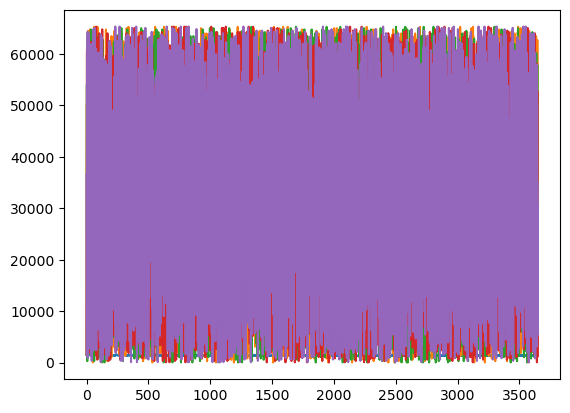

In [ ]:
CCD = AlphalasCCD()
inttimes = [10000, 50000, 100000, 500000, 1000000]
for inttime in inttimes:
    data = CCD.capture(inttime)
    plt.plot(data)
    
CCD.close_device()

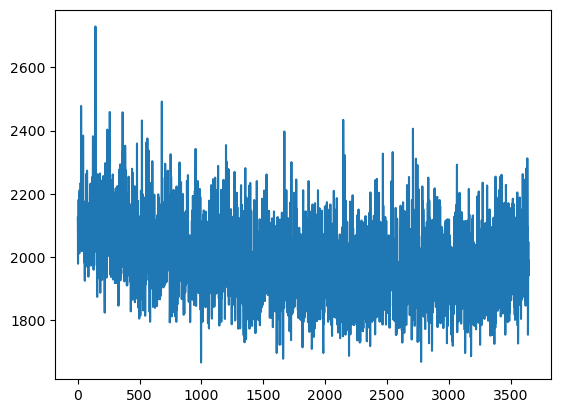

In [21]:

frame_numbers = [60,60,60,20,10]
frame_numbers = [1,1,1,1,1]
inttimes = [10000, 50000, 100000, 500000, 1000000]


CCD = AlphalasCCD()
master_darks = []
for inttime in inttimes:

    datas= []
    for frame_number in frame_numbers:
        print(f'frame_number: {frame_number}, inttime: {inttime}')
        data = CCD.capture(inttime)
        datas.append(data)
    master_dark = np.median(datas, axis=0)
    master_darks.append(master_dark)
    
CCD.close_device()


        



Connected to device: 
{'index': 0, 'flags': 2, 'type': 6, 'id': 67330064, 'location': 529, 'serial': b'58E862B3BEE1ACA', 'description': b'CCD-S3600-D(-UV) A', 'handle': c_void_p(None)}
frame_number: 1, inttime: 10000
frame_number: 1, inttime: 10000
frame_number: 1, inttime: 10000
frame_number: 1, inttime: 10000
frame_number: 1, inttime: 10000
frame_number: 1, inttime: 50000
frame_number: 1, inttime: 50000
frame_number: 1, inttime: 50000
frame_number: 1, inttime: 50000
frame_number: 1, inttime: 50000
frame_number: 1, inttime: 100000
frame_number: 1, inttime: 100000
frame_number: 1, inttime: 100000
frame_number: 1, inttime: 100000
frame_number: 1, inttime: 100000
frame_number: 1, inttime: 500000
frame_number: 1, inttime: 500000
frame_number: 1, inttime: 500000
frame_number: 1, inttime: 500000
frame_number: 1, inttime: 500000
frame_number: 1, inttime: 1000000
frame_number: 1, inttime: 1000000
frame_number: 1, inttime: 1000000
frame_number: 1, inttime: 1000000
frame_number: 1, inttime: 100

Connected to device: 
{'index': 0, 'flags': 2, 'type': 6, 'id': 67330064, 'location': 529, 'serial': b'58E862B3BEE1ACA', 'description': b'CCD-S3600-D(-UV) A', 'handle': c_void_p(None)}
 inttime: 1000, frame_number: 1,
 inttime: 1000, frame_number: 2,
 inttime: 1000, frame_number: 3,
 inttime: 1000, frame_number: 4,
 inttime: 1000, frame_number: 5,
 inttime: 1000, frame_number: 6,
 inttime: 1000, frame_number: 7,
 inttime: 1000, frame_number: 8,
 inttime: 1000, frame_number: 9,
 inttime: 1000, frame_number: 10,
 inttime: 1000, frame_number: 11,
 inttime: 1000, frame_number: 12,
 inttime: 1000, frame_number: 13,
 inttime: 1000, frame_number: 14,
 inttime: 1000, frame_number: 15,
 inttime: 1000, frame_number: 16,
 inttime: 1000, frame_number: 17,
 inttime: 1000, frame_number: 18,
 inttime: 1000, frame_number: 19,
 inttime: 1000, frame_number: 20,
 inttime: 1000, frame_number: 21,
 inttime: 1000, frame_number: 22,
 inttime: 1000, frame_number: 23,
 inttime: 1000, frame_number: 24,
 inttime

AttributeError: module 'matplotlib.pyplot' has no attribute 'savetxt'

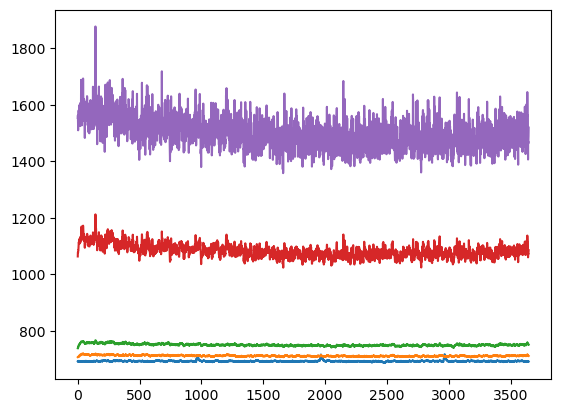

In [ ]:
frame_numbers = [60, 60, 60, 60, 60]
inttimes = [1000, 5000, 10000, 50000, 100000]
CCD = AlphalasCCD()
master_darks = []
for (inttime, frame_number) in zip(inttimes, frame_numbers):
    datas = []
    for i in range(frame_number):
        print(f' inttime: {inttime}, frame_number: {i+1},')
        data = CCD.capture(inttime)
        datas.append(data)
    master_dark = np.mean(datas, axis=0)
    plt.plot(master_dark)
    master_darks.append(master_dark)




CCD.close_device()

In [33]:
np.savetxt('master_darks.txt', master_darks)


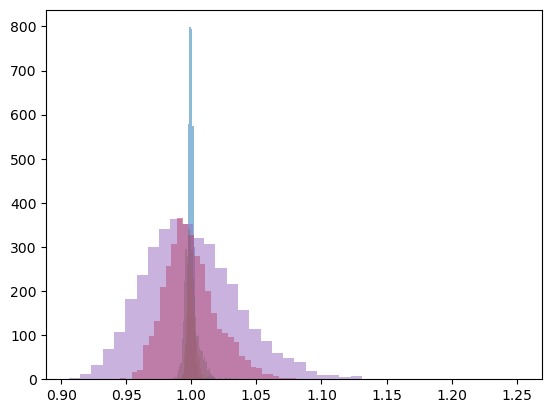

In [35]:

for master_dark in master_darks:
    plt.hist(master_dark /  np.mean(master_dark) , bins=40, alpha=0.5)

plt.show()